<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [102]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_train = df_train

df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]
df_validation = df_validation

values_to_predict = ['x', 'y', 'u', 'v']

IMG_SIZE = 128
BATCH_SIZE = 512

#Try std normalization and zero mean dataset, 
#learn std and mean from train and use for validation
#shuffle = True by default

train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False,
    class_mode = "raw")

Found 10259 validated image filenames.
Found 3101 validated image filenames.


In [105]:
df_validation

,filename,x,y,u,v
0,8L002680.jpg,5.035417,-7.504793,0.999436,-0.033528
1,8L002700.jpg,5.035449,-7.504677,0.999435,-0.033553
2,8L002720.jpg,5.035523,-7.504660,0.999435,-0.033551
3,8L002740.jpg,5.035512,-7.504735,0.999436,-0.033520
4,8L002760.jpg,5.035472,-7.504713,0.999435,-0.033536
...,...,...,...,...,...
3096,8L073820.jpg,4.804142,-7.879104,0.999562,-0.029563
3097,8L073840.jpg,4.802425,-7.876738,0.999659,-0.026088
3098,8L073860.jpg,4.802549,-7.875700,0.999642,-0.026725
3099,8L073880.jpg,4.803946,-7.870023,0.999591,-0.028564


In [62]:
val = df_validation.to_numpy()
tr = df_train.to_numpy()
print("Validation limits min: ", np.min(val[:,1:3], axis=0))
print("Train limits min: ", np.min(tr[:,1:3], axis=0))
print("Validation limits max: ", np.max(val[:,1:3], axis=0))
print("Train limits max: ", np.max(tr[:,1:3], axis=0))


Validation limits min:  [-20.211285999999998 -8.967146000000001]
Train limits min:  [-20.153133 -9.265061]
Validation limits max:  [19.571617 7.59713]
Train limits max:  [19.770398999999998 7.834498]


# **Visualizing some images**

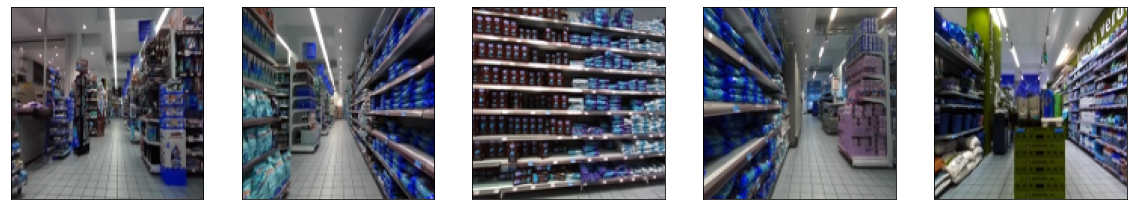

x    y   u   v
[[-0.477179 -3.453613 -0.999784 -0.020756999999999998]
 [1.137534 6.655639 -0.997914 0.06453500000000001]
 [-3.889679 5.918492 0.151944 0.988389]
 [-0.457117 6.910328 0.999697 0.024597]
 [5.191205 -7.767975 0.9984280000000001 -0.055958]]


In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
np.random.shuffle(train)
files_train = train[:,0]

x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

print("x    y   u   v")
print(train[:N_IMAGES, 1:5])

# **Training the model**

In [76]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, BatchNormalization, Dropout, ReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model = Sequential([
            Conv2D(16, (3,3), activation = 'relu', padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),
            MaxPooling2D((2, 2), padding='same'),#64x64x16
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x32
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#16x16x64
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x128
            Flatten(),
            Dense(128, activation='relu'),
            Dense(4)                                       
])

# model = Sequential([
#             Conv2D(16, (3,3), padding='same',
#                 input_shape = (IMG_SIZE,IMG_SIZE,3)),          
#             # Conv2D(16, (5, 5), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.4),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 2), padding='same'),
#             # Conv2D(32, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.5),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(32, (3, 3), padding='same'),
#             # Conv2D(64, (3, 3), activation='relu', padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.6),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.7),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(64, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.8),
#             MaxPooling2D((2, 2), padding='same'),

#             Conv2D(256, (3, 3), padding='same'),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             MaxPooling2D((2, 2), padding='same'),

#             Flatten(),
#             Dense(4),
#             BatchNormalization(),
#             ReLU(),
#             Dropout(rate=0.9),
#             # Dense(512),
#             # Dense(4) #Linear activation to obtain full range [-inf, +inf] bc of regression
# ])

model.summary()

optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath = "/content/drive/My Drive/Colab_Notebooks/CV_Project/"
filepath_models = filepath + "saved_models/weights-improvement-{epoch:02d}-{val_loss:2f}.hdf5"
filepath_csv = filepath + "loss/my_logs.csv"

checkpoint = ModelCheckpoint(filepath_models, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", min_delta = 1, 
                           patience = 5, verbose = 1)
log_csv = CSVLogger(filepath_csv, separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

history = model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    workers = 8)



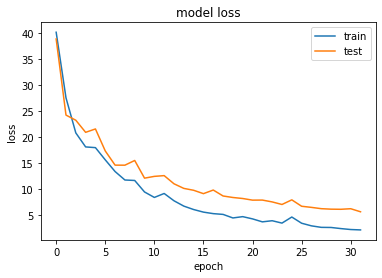

In [79]:
training_log = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/my_logs.csv").to_numpy()

loss = training_log[:,1]
val_loss = training_log[:,2]

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/" + 'loss.png')
plt.show()

In [132]:
from keras.models import load_model
import numpy as np
import math  

path = "/content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/weights-improvement-32-5.637294.hdf5"

model = load_model(path)

predicted = model.predict(validation_dataset, batch_size = 128)
target = df_validation.to_numpy()[:,1:]


def evaluate_localization(predicted, target):
    """Evaluates localization results.
        Input:
            predicted: matrix of N x 4 real numbers (x,y,u,v)
                       representing the predicted 2D location (x,y)
                       and the orientation (u,v)

            target:    ground truth locations/orientations in the same form of predicted
            
        Output:
            (position_error, orientation_error)"""

    position_errors = np.sqrt(((predicted[:,:2]-target[:,:2])**2).sum(1).tolist())

    def normalize(x):
        return x/np.sqrt((x**2).sum(1).tolist()).reshape(-1,1)

    predicted_orientations = normalize(predicted[:,2:])
    target_orientations = normalize(target[:,2:])

    orientation_errors = np.degrees(np.arccos((predicted_orientations*target_orientations).sum(1).tolist()))

    return position_errors.mean(), np.median(position_errors), np.mean(orientation_errors), np.median(orientation_errors)


errors = evaluate_localization(predicted,target)

print("Errors:")
print("Mean Location Error: %0.4f m" % (errors[0],))
print("Median Location Error: %0.4f m" % (errors[1],))
print("Mean Orientation Error: %0.4f °" % (errors[2],))
print("Median Orientation Error: %0.4f °" % (errors[3],))

Errors:
Mean Location Error: 3.6177 m
Median Location Error: 2.8081 m
Mean Orientation Error: 40.3800 °
Median Orientation Error: 25.4988 °


In [127]:
import math
print(np.sqrt(((predicted[:,:2]-target[:,:2])**2).sum(1).tolist()))

[0.46396368 0.61554147 0.60593496 ... 0.28721378 0.24218253 0.26117466]
